# OTOC definition with Operators

We use a symmetrized version for the finite temperature OTOC calculation
$$O_S\left[\rho_\beta\right](t)=\operatorname{Tr}\left(\rho_\beta^{1 / 4} W(t) \rho_\beta^{1 / 4} V \rho_\beta^{1 / 4} W(t) \rho_\beta^{1 / 4} V\right)$$
where, $\rho_\beta=\frac{\exp(-\beta H)}{\mathrm{Tr}(\exp(-\beta H))}$

In [1]:
#import usual libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import sparse
from numpy import linalg as LA
from scipy import linalg as sLA
from scipy.sparse.linalg import eigs
from IPython.display import display, Latex
from decimal import *
import pandas as pd
import math
from qiskit.visualization import plot_histogram
from qiskit.visualization import *
from qiskit.circuit.library import iSwapGate
from scipy.linalg import expm
from scipy.stats import unitary_group
from IPython.core.interactiveshell import InteractiveShell
from utils_operators import *
from utils_observables import *
#from bristol.ensembles import Circular
from itertools import cycle
from functools import reduce
import sys
from scipy.io import mmread
from qiskit.visualization import array_to_latex

mycolor=cycle('krcbm')
mymarker=cycle('oxs^v')

InteractiveShell.ast_node_interactivity = "all"
getcontext().prec = 30


# Main Body of the code

In [2]:
N=6
instance_id=3
mybeta=0.01
delt=1.5
nstep=6
nq=N//2
mmax=2**nq
Jsqr=1

totalT=delt*nstep
mytimes1=np.arange(0,totalT+delt/2,delt)
mytimes1
Wqubit=1
Vqubit=0

Wsp=2 # what kind of operator
Vsp=2

write_eigenstate_file=0
print("*************************************")
print("check Pauli (sigma) factors in Hamiltonian, and sigma_0 and V_op variable in main code")

array([0. , 1.5, 3. , 4.5, 6. , 7.5, 9. ])

*************************************
check Pauli (sigma) factors in Hamiltonian, and sigma_0 and V_op variable in main code


# Read SYK Hamiltonian from file

In [3]:
syk_op = mmread("N%d_configs/H_N%d_%d.mtx" %(N,N,instance_id))
syk_op=np.array(syk_op)

# Exact Diagonalization

In [12]:
mybeta

0.01

array([0.99999863, 0.86267583, 0.54237354, 0.23447817, 0.07651373,
       0.05672934, 0.06604644])

Text(0, 0.5, '$ O(t) $')

Text(0.5, 0, '$t$')

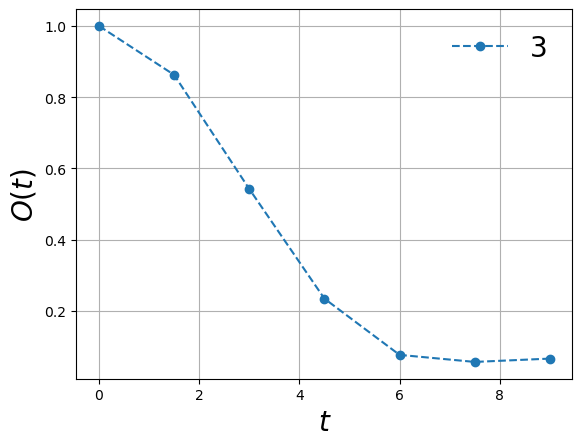

In [4]:

exact_nstep=int(1*nstep)   # extraFactor*nstep #2000
exact_delt=totalT/exact_nstep  #1000/2000=0.5  #0.5*2000=1000

rho_beta=density_matrix(syk_op,mybeta)
#rho_beta=(np.eye(mmax)-mybeta*syk_op)/((np.eye(mmax)-mybeta*syk_op).trace())
#print("********",np.real(rho_beta.trace()), np.real(np.trace(rho_beta)) )
#np.allclose(rho_beta,sLA.expm(-mybeta*syk_op))
rho_beta2= sLA.sqrtm(rho_beta) 
rho_beta4= sLA.sqrtm(rho_beta2) 


times1=np.zeros(exact_nstep+1)
OTOC_t=np.zeros(exact_nstep+1)

otoc_syk=np.zeros(len(times1))

for nst in range(exact_nstep+1):
    #print(nst)

    tt=nst*exact_delt
    #print(tt)
    times1[nst]=tt
    W= sigma_creator(nq,Wqubit,Wsp) # W operator in OTOC
    V=sigma_creator(nq,Vqubit,Vsp)
    
    
    otoc_syk[nst]=otoc(rho_beta4,tt,syk_op,W,V)



otoc_syk

plt.plot(times1,otoc_syk,marker=next(mymarker),ls='--',label=r'%d' %instance_id)
plt.legend(loc='best',frameon=False,fontsize=20)
plt.ylabel(r'$ O(t) $',fontsize=20)
plt.xlabel(r'$t$',fontsize=20)
plt.grid()
#plt.savefig(r'ED_data/all_ED_N6.png',bbox_inches='tight')
plt.show()
plt.close()
    



In [5]:
otoc_syk

array([0.99999863, 0.86267583, 0.54237354, 0.23447817, 0.07651373,
       0.05672934, 0.06604644])

In [6]:
print("writing data at beta ", mybeta)
mydata=np.transpose([times1,1-otoc_syk])
df=pd.DataFrame(mydata)
df.to_csv('ED_id%d_beta%0.1f_dt%0.1f'%(instance_id,mybeta,delt),sep='\t',header=None,index=False,mode='w')

writing data at beta  0.01


# Trotter

In [7]:


def pauli_string_to_array(pauli_string):
    pauli_mapping = {
        'I': np.eye(2),  # Identity matrix
        'X': sigX(),  # Pauli-X matrix
        'Y': sigY(),  # Pauli-Y matrix
        'Z': sigZ()  # Pauli-Z matrix
    }


    # Iterate through the characters in the Pauli string and multiply corresponding matrices
    for i,char in enumerate(pauli_string):
        pauli_matrix = pauli_mapping.get(char)
        if i==0:
            pauli_array=pauli_matrix
        else:
            # Multiply the current array with the Pauli matrix using numpy.dot
            pauli_array = np.kron(pauli_array,pauli_matrix)

    # Now, pauli_array contains the matrix representation of the Pauli string
    return pauli_array

#np.allclose( pauli_string_to_array('ZYX'), np.kron(np.kron(sigZ(),sigY()), sigX())  )
  

(5, 8, 8)

(5, 8, 8)

(5, 8, 8)

Text(0, 0.5, '$ O(t) $')

Text(0.5, 0, '$t$')

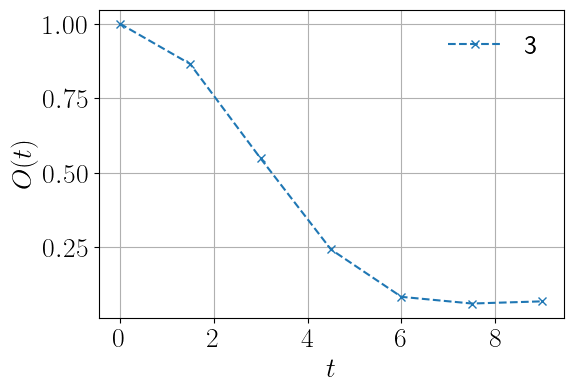

In [8]:
#exp()Wexp()Vexp()Wexp()V

want_trotterized=1


if want_trotterized:
    
    otoc_trotterval_instancearr=[]
    
    plt.rc('text',usetex=True)
    fig, ax = plt.subplots(facecolor='w',figsize=(6,4))
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    
    
    ham_filename='N6_configs/ham_paulis_N6_%d.txt' %instance_id

    # commutating list and noncommutating index
    X=np.array(pd.read_csv(ham_filename,sep=',',index_col=None,header=None))

    commuting_list=np.array( [[0,10,13],[1,7,11],[2,5,9],[3,8,14],[4,12,6]] )

    #for i in range(len(commuting_list)):
    #    print(X[commuting_list[i,0],0],X[commuting_list[i,1],0],X[commuting_list[i,2],0]  )



    non_commutating_array=[]

    for i in range(len(commuting_list)):
        non_commutating_array.append( X[commuting_list[i][0],1]*pauli_string_to_array(X[commuting_list[i][0],0] )\
                                    +X[commuting_list[i][1],1]*pauli_string_to_array(X[commuting_list[i][1],0] )\
                                    +X[commuting_list[i][2],1]*pauli_string_to_array(X[commuting_list[i][2],0] )) 
    non_commutating_array=np.array(non_commutating_array)

    non_commutating_array.shape




    non_commutating_exponentiated=[]


    for i in range(len(non_commutating_array)):
        non_commutating_exponentiated.append(sLA.expm(-1.0j*delt*non_commutating_array[i]) )

    non_commutating_exponentiated=np.array(non_commutating_exponentiated)
    non_commutating_exponentiated.shape

    mytrotterized_H=np.eye(mmax)
    for i in range(len(non_commutating_exponentiated)):
        mytrotterized_H= mytrotterized_H @ non_commutating_exponentiated[i,:] 


    non_commutating_exponentiated2=[]


    for i in range(len(non_commutating_array)):
        non_commutating_exponentiated2.append(sLA.expm(1.0j*delt*non_commutating_array[i]) )

    non_commutating_exponentiated2=np.array(non_commutating_exponentiated2)
    non_commutating_exponentiated2.shape
    mytrotterized_H2=np.eye(mmax)
    for i in range(len(non_commutating_exponentiated2)):
        mytrotterized_H2= mytrotterized_H2 @ non_commutating_exponentiated2[i,:]

    #######################################################################
    #nstep=8
    #Wqubit=3
    #Vqubit=1

    rho_beta=density_matrix(syk_op,mybeta)
    #rho_beta=(np.eye(mmax)-mybeta*syk_op)/((np.eye(mmax)-mybeta*syk_op).trace())
    #print("********",np.real(rho_beta.trace()), np.real(np.trace(rho_beta)) )
    #np.allclose(rho_beta,sLA.expm(-mybeta*syk_op))
    rho_beta2= sLA.sqrtm(rho_beta) 
    rho_beta4= sLA.sqrtm(rho_beta2) 


    otoc_trotterval=[]
    otoc_trotterval.append(1)

    for i in range(1,nstep+1):
        P=mytrotterized_H2  # 1jdtH
        Q=mytrotterized_H #-1jdtH
        for j in range(2,i+1):
            P=P @ mytrotterized_H2
            Q=Q @ mytrotterized_H
        #Wt= P @ (sigma_creator(nq,Wqubit,2) @ Q)



        Wt=P  @ (sigma_creator(nq,Wqubit,2) @ Q)



        Vop=sigma_creator(nq,Vqubit,2)

        mytempop= (rho_beta4 @ Wt @ rho_beta4 @ Vop) @ (rho_beta4 @ Wt @ rho_beta4 @ Vop)

        
        mytempotoc=np.real(np.trace(mytempop))
        #print(np.real(np.trace(mytempop)),np.real(np.trace(mytempop2)))

        otoc_trotterval.append(mytempotoc)




    otoc_trotterval= np.real(otoc_trotterval) 

    #plt.plot(times1,np.real(meas0),c='b',label='ED')
    plt.plot(times1,otoc_trotterval,marker=next(mymarker),ls='--',label=r'%d' %instance_id) 
    plt.legend(loc='best',frameon=False,fontsize=20)
    plt.ylabel(r'$ O(t) $',fontsize=20)
    plt.xlabel(r'$t$',fontsize=20)
    plt.grid()
    #plt.savefig(r'ED_data/all_trotter_N6.png',bbox_inches='tight')
    plt.show()
    plt.close()

Text(0, 0.5, '$ O(t) $')

Text(0.5, 0, '$t$')

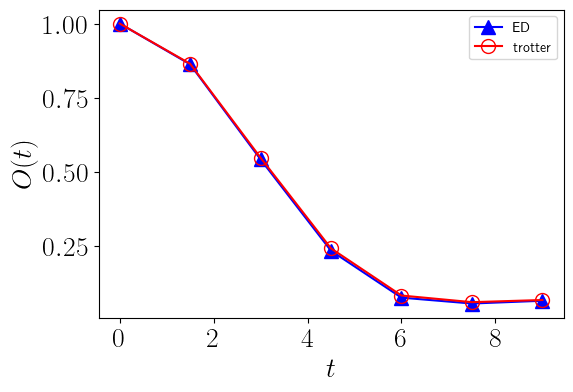

In [9]:
comparison_ED_trotter=1
if comparison_ED_trotter:
    plt.rc('text',usetex=True)
    fig, ax = plt.subplots(facecolor='w',figsize=(6,4))
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.plot(times1,otoc_syk,marker='^',ms=10,c='b',label=r'ED')
    plt.plot(times1,otoc_trotterval,'or',ms=10,mfc='None',ls='-',label=r'trotter') 
    plt.legend()
    plt.ylabel(r'$ O(t) $',fontsize=20)
    plt.xlabel(r'$t$',fontsize=20)
    #plt.savefig(r'delt_%d' % delt,bbox_inches='tight')

In [10]:
write_trotter_data=1
if write_trotter_data:
    mydata=np.transpose([times1,1.0-trotter_val])
    df=pd.DataFrame(mydata)
    df.to_csv('trotter_id%d_dt%0.1f'%(instance_id,delt),sep='\t',header=None,index=False,mode='w')

NameError: name 'trotter_val' is not defined